# Cell Types Project
*Replace this with the name of your project*

## Team Member Names & Contributions
*Feel free to name your team, but please also include your real names and IDs here. Please specify who in your group worked on which parts of the project.*

- **Claire Gao**:
- **Pawel Vijayakumar**: 
- **Devin Chang**: 

## Abstract

*Fill in your 3-4 sentence abstract here*

## Research Question

Is there a correlation between gene expression and electrophysiological features across neurons in layer III of the medial entorhinal cortex and CA1 pyramidal neurons and could this relationship offer insight into the function of the perforant pathway? 

# Background and Prior Work

*Fill in your background and prior work here (~500 words). You are welcome to use additional subheadings. You should also include a paragraph describing each dataset and how you'll be using them.* 

### References (include links):
(1)

(2)

## Hypothesis


*Fill in your hypotheses here*

## Setup
*Are there packages that need to be imported, or datasets that need to be downloaded?*

In [1]:
## Import required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.cluster.hierarchy import linkage, leaves_list

## Data Wrangling

### 1. RNA-seq Dataset from Allen Brain Institute

The RNA-seq gene expression dataset for mouse (and rats) are read into a dataframe (mouse_rnaseq_df). The first five rows of the dataframe is displayed below.  

As shown in the dataset, the first column of the dataset ('feature') contains the names of genes which gene expression was measured through RNA-seq. The rest of the columns in the dataframe stores the gene expression values (not normalized) of all recorded genes for cells in the corresponding brain region. In each column name, the number in the name indicates where the neuron projects to, and the abbreviation that follows shows which brain region the gene expression was recorded. The dataset does not contain null values. However, only the middle 25% to 75% of the gene expression values are included in this dataset to exclude gene expression values at both extremes. Gene expression values below the 75 percentile and above the 25 percentile are trimmed and stored as 0 in the dataset. Therefore, to summarize, each row of the dataset contains the trimmed gene expression values for the corresponding gene in the 'feature' column across all brain regions.

In [2]:
# Read mouse RNA-seq data into a dataframe
mouse_rnaseq_df = pd.read_csv('data/mouse_rna_seq/mouse_gene_expression.xls')

# View a few rows of mouse_rnaseq_df
mouse_rnaseq_df.head()

,feature,108_Pvalb,229_L6 IT CTX,26_Ntng1 HPF,67_Sst,6_Lamp5 Lhx6,111_Pvalb,359_CA2-IG-FC,238_Car3,347_CA1-do,...,50_Vip,190_L4/5 IT CTX,207_L5/6 IT CTX,342_CA1,260_L5 PT CTX,324_ProS,178_L4 IT CTX,284_L6 CT CTX,377_Astro,298_L6 CT ENT
0,Xkr4,9.897312,9.071378,9.185962,10.240623,9.660534,10.031727,8.514091,8.106954,8.89654,...,9.317501,8.843498,8.935291,9.783714,7.377046,7.797887,8.196732,8.876808,0.0,9.064276
1,Gm1992,0.000000,0.000000,0.000000,0.310545,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.257404,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,Gm37381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,Rp1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,Sox17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


Since the original dataframe has cells as the column names and gene names as one of its columns (the 'feature' column), we decide to set the index of the dataframe to the gene name and use the transpose of the dataframe to make the cells as rows and genes as columns. Since a gene expression value of 0 indicates either that the gene was no expressed or that the value was trimmed, columns with all entries as 0 does not provide useful information for analysis, so they are removed from the dataframe. The gene expression values for each column are then normalized with mean and standard deviation, and the first five rows of the normalized dataframe is displayed below.

In [3]:
# Set the index for the RNA-seq dataframe as the features and take the transpose
mouse_rnaseq_df = mouse_rnaseq_df.set_index('feature').T

# Removing columns with all entries 0
mouse_rnaseq_df = mouse_rnaseq_df.loc[:, mouse_rnaseq_df.sum() != 0]

# Normalization of RNA-seq data
normalized_rnaseq_df = (mouse_rnaseq_df - mouse_rnaseq_df.mean()) / mouse_rnaseq_df.std() 
normalized_rnaseq_df.head()

feature,Xkr4,Gm1992,Sox17,Mrpl15,Gm37988,Tcea1,Rgs20,Atp6v1h,Oprk1,Npbwr1,...,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,Vamp7,Spry3,Tmlhe,AC149090.1,CAAA01118383.1
108_Pvalb,0.652275,-0.20522,-0.050833,0.049980,-0.079335,-0.330950,0.077321,-0.220597,-0.138069,-0.076959,...,0.845659,1.602800,0.641492,-0.296222,1.464125,-0.677771,-0.081271,-0.150055,-0.951936,-0.052934
229_L6 IT CTX,0.271654,-0.20522,-0.050833,-0.283897,-0.079335,-0.330950,0.210029,0.393482,4.455433,-0.076959,...,0.701727,0.100556,0.397990,-0.296222,-0.118838,-0.033920,-0.081271,-0.150055,0.644068,-0.052934
26_Ntng1 HPF,0.324458,-0.20522,-0.050833,-0.303867,-0.079335,3.796175,-0.704332,0.104229,-0.138069,-0.076959,...,0.815959,0.557708,0.400534,-0.296222,0.794759,1.683014,-0.081271,-0.150055,0.853209,-0.052934
67_Sst,0.810485,0.72375,-0.050833,-0.303867,-0.079335,-0.122366,-0.670367,-0.040336,-0.138069,-0.076959,...,-1.001102,-1.071007,-0.019942,-0.296222,-0.913146,-0.096065,-0.081271,-0.150055,0.677334,-0.052934
6_Lamp5 Lhx6,0.543159,-0.20522,-0.050833,-0.303867,-0.079335,-0.330950,-0.704332,-0.467332,-0.138069,-0.076959,...,0.631076,0.638271,0.352583,-0.296222,0.720333,-0.537491,-0.081271,-0.150055,0.752276,-0.052934


The dataset contains the gene expression of genes across many different cells at different brain regions. However, since we are interested in investigating the gene expression of neurons from CA1 and layer 3 of the medial entorhinal cortex, we isolate the normalized RNA-seq data for only the cells at the two brain regions. The normalized RNA-seq data for the two brain regions are then stored in separate dataframes for further analysis. The first five  rows of each dataframe are displayed below.

In [4]:
rnaseq_cell_list = list(normalized_rnaseq_df.index)
CA1_samples = []
ENT_samples = []
for cell in rnaseq_cell_list:
    if ('CA1' in cell) and ('-' not in cell):
        CA1_samples.append(cell)
    elif ('ENTm' in cell) and ('L3' in cell):
        ENT_samples.append(cell)
CA1_rnaseq_data = normalized_rnaseq_df.loc[CA1_samples]     # Only keeping RNA-seq data for CA1
ENT_rnaseq_data = normalized_rnaseq_df.loc[ENT_samples]     # Only keeping RNA-seq data for Medial Entorhinal Cortex

In [5]:
CA1_rnaseq_data.head()

feature,Xkr4,Gm1992,Sox17,Mrpl15,Gm37988,Tcea1,Rgs20,Atp6v1h,Oprk1,Npbwr1,...,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,Vamp7,Spry3,Tmlhe,AC149090.1,CAAA01118383.1
344_CA1,0.281291,-0.205220,-0.050833,-0.303867,-0.079335,-0.33095,-0.704332,-0.175213,-0.138069,-0.076959,...,-1.021343,-1.653870,-0.328352,-0.296222,-1.579588,-0.791263,-0.081271,-0.150055,0.622166,-0.052934
337_CA1,-0.011241,-0.205220,-0.050833,-0.303867,-0.079335,-0.33095,-0.704332,0.082840,-0.138069,-0.076959,...,-1.007100,-1.257491,-0.104084,-0.296222,-1.118058,-0.466288,-0.081271,-0.150055,0.857840,-0.052934
338_CA1,0.362362,-0.205220,-0.050833,-0.303867,-0.079335,-0.33095,-0.704332,-0.100671,-0.138069,-0.076959,...,-0.927732,-1.370446,-0.164602,-0.296222,-1.338095,-0.524836,-0.081271,-0.150055,0.895127,-0.052934
341_CA1,0.409429,1.823382,-0.050833,-0.303867,-0.079335,-0.33095,-0.704332,-0.850982,-0.138069,-0.076959,...,-1.113570,-2.270835,-0.469021,-0.296222,-2.251991,-0.816005,-0.081271,-0.150055,0.709414,-0.052934
340_CA1,0.503818,0.329662,-0.050833,-0.303867,-0.079335,-0.33095,-0.704332,0.283226,-0.138069,-0.076959,...,-0.779323,-1.581206,-0.212966,-0.296222,-1.402687,-0.440975,-0.081271,-0.150055,0.803297,-0.052934


In [6]:
ENT_rnaseq_data.head()

feature,Xkr4,Gm1992,Sox17,Mrpl15,Gm37988,Tcea1,Rgs20,Atp6v1h,Oprk1,Npbwr1,...,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,Vamp7,Spry3,Tmlhe,AC149090.1,CAAA01118383.1
137_L3 IT ENTm,0.305626,-0.20522,-0.050833,-0.303867,-0.079335,-0.33095,-0.704332,-0.666062,-0.138069,-0.076959,...,-0.936146,-0.806799,0.250999,-0.296222,-0.154319,-0.145390,-0.081271,-0.150055,1.101821,-0.052934
138_L3 IT ENTm,0.103229,-0.20522,-0.050833,-0.150656,-0.079335,-0.33095,0.309071,0.306822,-0.138069,-0.076959,...,0.522742,-0.850013,0.140708,-0.296222,-0.203677,1.391652,-0.081271,-0.150055,1.023550,-0.052934
135_L3 IT ENTm,0.289206,-0.20522,-0.050833,-0.303867,-0.079335,-0.33095,-0.649187,-0.082160,-0.138069,-0.076959,...,-0.607178,-0.841073,0.177856,-0.296222,-0.274083,0.255548,-0.081271,-0.150055,1.050162,-0.052934
136_L3 IT ENTm,0.429230,-0.20522,-0.050833,-0.303867,-0.079335,-0.33095,-0.704332,-0.910717,-0.138069,-0.076959,...,-1.344930,-1.015198,0.195206,-0.296222,-0.410178,-0.816005,-0.081271,-0.150055,1.061763,-0.052934


## 2. Electrophysiological Features Dataset

The electrophysiological features dataset is also read into a dataframe (mouse_ephys_df) below. The first five rows of the dataset are displayed.

The first 27 rows contains measurements of different electrophysiological features for different cell types. These columns contain a lot of null values, which could be dealt with through data wrangling. The rest of the columns in the dataset contains general information such as but not limited to the information about the mouse used to conduct the experiment, the authors and paper that published the data, and the cell types which the data were recorded from. 

In [7]:
# Read mouse Neuroelectro ephys data into a DataFrame
mouse_ephys_df = pd.read_excel('data/neuroelectro/neurophysiology_data.xlsx')

# View a few rows of mouse_ephys_data
mouse_ephys_df.head()

,CellCapacitance,InputResistance,RestingMembranePotential,MembraneTimeConstant,SpikeAmplitude,SpikeHalfWidth,SpikeThreshold,Rheobase,FiringFrequency,AhpDuration,...,Temp,Age,Weight,NeuronType,Title,PubYear,PubmedLink,DataTableLinks,ArticleLink,LastAuthor
0,NaN,457.0,-57.9,NaN,64.0,1.5,NaN,NaN,NaN,NaN,...,34.0,6.5,NaN,Abducens nucleus motor neuron,A- T- and H-type currents shape intrinsic firi...,2003,http://www.ncbi.nlm.nih.gov/pubmed/12651919/,http://neuroelectro.org/data_table/11076/,http://neuroelectro.org/article/45731/,Debanne D
1,NaN,59.0,-61.0,17.0,92.1,NaN,-43.0,NaN,NaN,NaN,...,32.0,44.0,NaN,Amygdala basolateral nucleus pyramidal neuron,Distinct subtypes of cholecystokinin (CCK)-con...,2009,http://www.ncbi.nlm.nih.gov/pubmed/19164102/,http://neuroelectro.org/data_table/242/,http://neuroelectro.org/article/26026/,Rainnie DG
2,NaN,63.0,-70.0,31.0,NaN,NaN,-35.5,NaN,NaN,NaN,...,31.0,49.0,NaN,Amygdala basolateral nucleus pyramidal neuron,Noradrenergic excitation of a subpopulation of...,2008,http://www.ncbi.nlm.nih.gov/pubmed/18950687/,http://neuroelectro.org/data_table/26660/,http://neuroelectro.org/article/30833/,Yanagawa Y
3,NaN,40.7,-73.7,NaN,61.0,NaN,-54.0,NaN,0.23,NaN,...,37.0,80.5,330.0,Amygdala basolateral nucleus pyramidal neuron,Cellular mechanisms of infralimbic and prelimb...,2002,http://www.ncbi.nlm.nih.gov/pubmed/11756516/,http://neuroelectro.org/data_table/2952/,http://neuroelectro.org/article/37269/,Grace AA
4,NaN,46.0,-63.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,...,32.0,38.0,135.0,Amygdala basolateral nucleus pyramidal neuron,Cholinergic responses of morphologically and e...,1997,http://www.ncbi.nlm.nih.gov/pubmed/9153654/,http://neuroelectro.org/data_table/24186/,http://neuroelectro.org/article/82009/,Criado JM


The electrophysiological feature dataset also contains lots of different cell types. We are interested in the hippocampus CA1 pyramidal cell and the medial entorhinal cortex layer III pyramidal cell, so we isolate the electrophysiological features measured from the two cell types from the dataset into two separate dataframes. Since we are only interested the electrophysiological features and not other general information, we drop all columns that contains non-electrophysiological data (paper, author names, animal information etc.). Furthermore, we also drop all columns that has only null values since they do not provide useful information when making comparison between the two cell types. The first five rows of the cleaned-up electrophysiological features data for CA1 and ENT are displayed below.

In [8]:
# Only keeping CA1 and ENT data
CA1_ephys_data = mouse_ephys_df[mouse_ephys_df['NeuronType'] == 'Hippocampus CA1 pyramidal cell']     
ENT_ephys_data = mouse_ephys_df[mouse_ephys_df['NeuronType'] == 'Medial entorhinal cortex layer III pyramidal cell']

# Drop columns with strings, non-ephys data, and all null values
CA1_ephys_data = (CA1_ephys_data.dropna(how='all', axis=1).select_dtypes(exclude=['object'])
                .drop(['Temp', 'Age', 'PubYear'], axis=1))
ENT_ephys_data = (ENT_ephys_data.dropna(how='all', axis=1).select_dtypes(exclude=['object'])
                .drop(['Temp', 'Age', 'PubYear'], axis=1))

In [9]:
CA1_ephys_data.head()

,CellCapacitance,InputResistance,RestingMembranePotential,MembraneTimeConstant,SpikeAmplitude,SpikeHalfWidth,SpikeThreshold,Rheobase,FiringFrequency,AhpDuration,...,SpontaneousFiringRate,FastAhpAmplitude,SlowAhpAmplitude,SlowAhpDuration,SpikeWidth,AdpAmplitude,SpikePeak,AdaptationRatio,JxnOffset,Weight
91,NaN,111.0,NaN,NaN,82.6,NaN,-37.9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,NaN,111.0,-60.1,NaN,NaN,1.52,-46.2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,NaN,35.4,-69.9,NaN,92.0,0.83,-58.9,NaN,NaN,NaN,...,NaN,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175.0
94,NaN,237.8,-61.7,29.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN
95,NaN,55.4,-66.2,40.3,112.0,0.95,-46.3,213.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
ENT_ephys_data.head()

,CellCapacitance,InputResistance,RestingMembranePotential,MembraneTimeConstant,SpikeAmplitude,SpikeHalfWidth,SpikeThreshold,AhpAmplitude
160,130.0,49.0,-55.0,NaN,NaN,0.5,NaN,7.0
161,NaN,76.9,-61.4,16.7,73.0,NaN,-45.6,NaN


## Data Analysis & Results

Since we are interested in what genes might contribute to the differences between the electrophysiological features of layer III ENTm pyramidal cells and CA1 pyramidal cells, we first examine the electrophysiological features that are different between the two cell types. To identify features that are different, we constructed boxplots to compare the values of each electrophysiological features for the two neuron types as displayed below. Since the electrophysiology data for ENTm pyramidal neuron only has two samples while containing null values, some of the boxplot below for ENTm neurons has only one datapoint. Only electrophysiological features that are present in both the columns of CA1_ephys_data and the columns of ENT_ephys_data are selected for comparison: cell capacitance, input resistance, resting membrane potential, membrane time constant, spike amplitude, spike half width, spike threshold, and AHP amplitude. The boxplots below shows that there are more differences in the values for cell capacitance, resting membrane potential, membrane time constant, spike amplitude, and spike half width between the two cell types than other electrophysiological features (the boxes don't overlap).

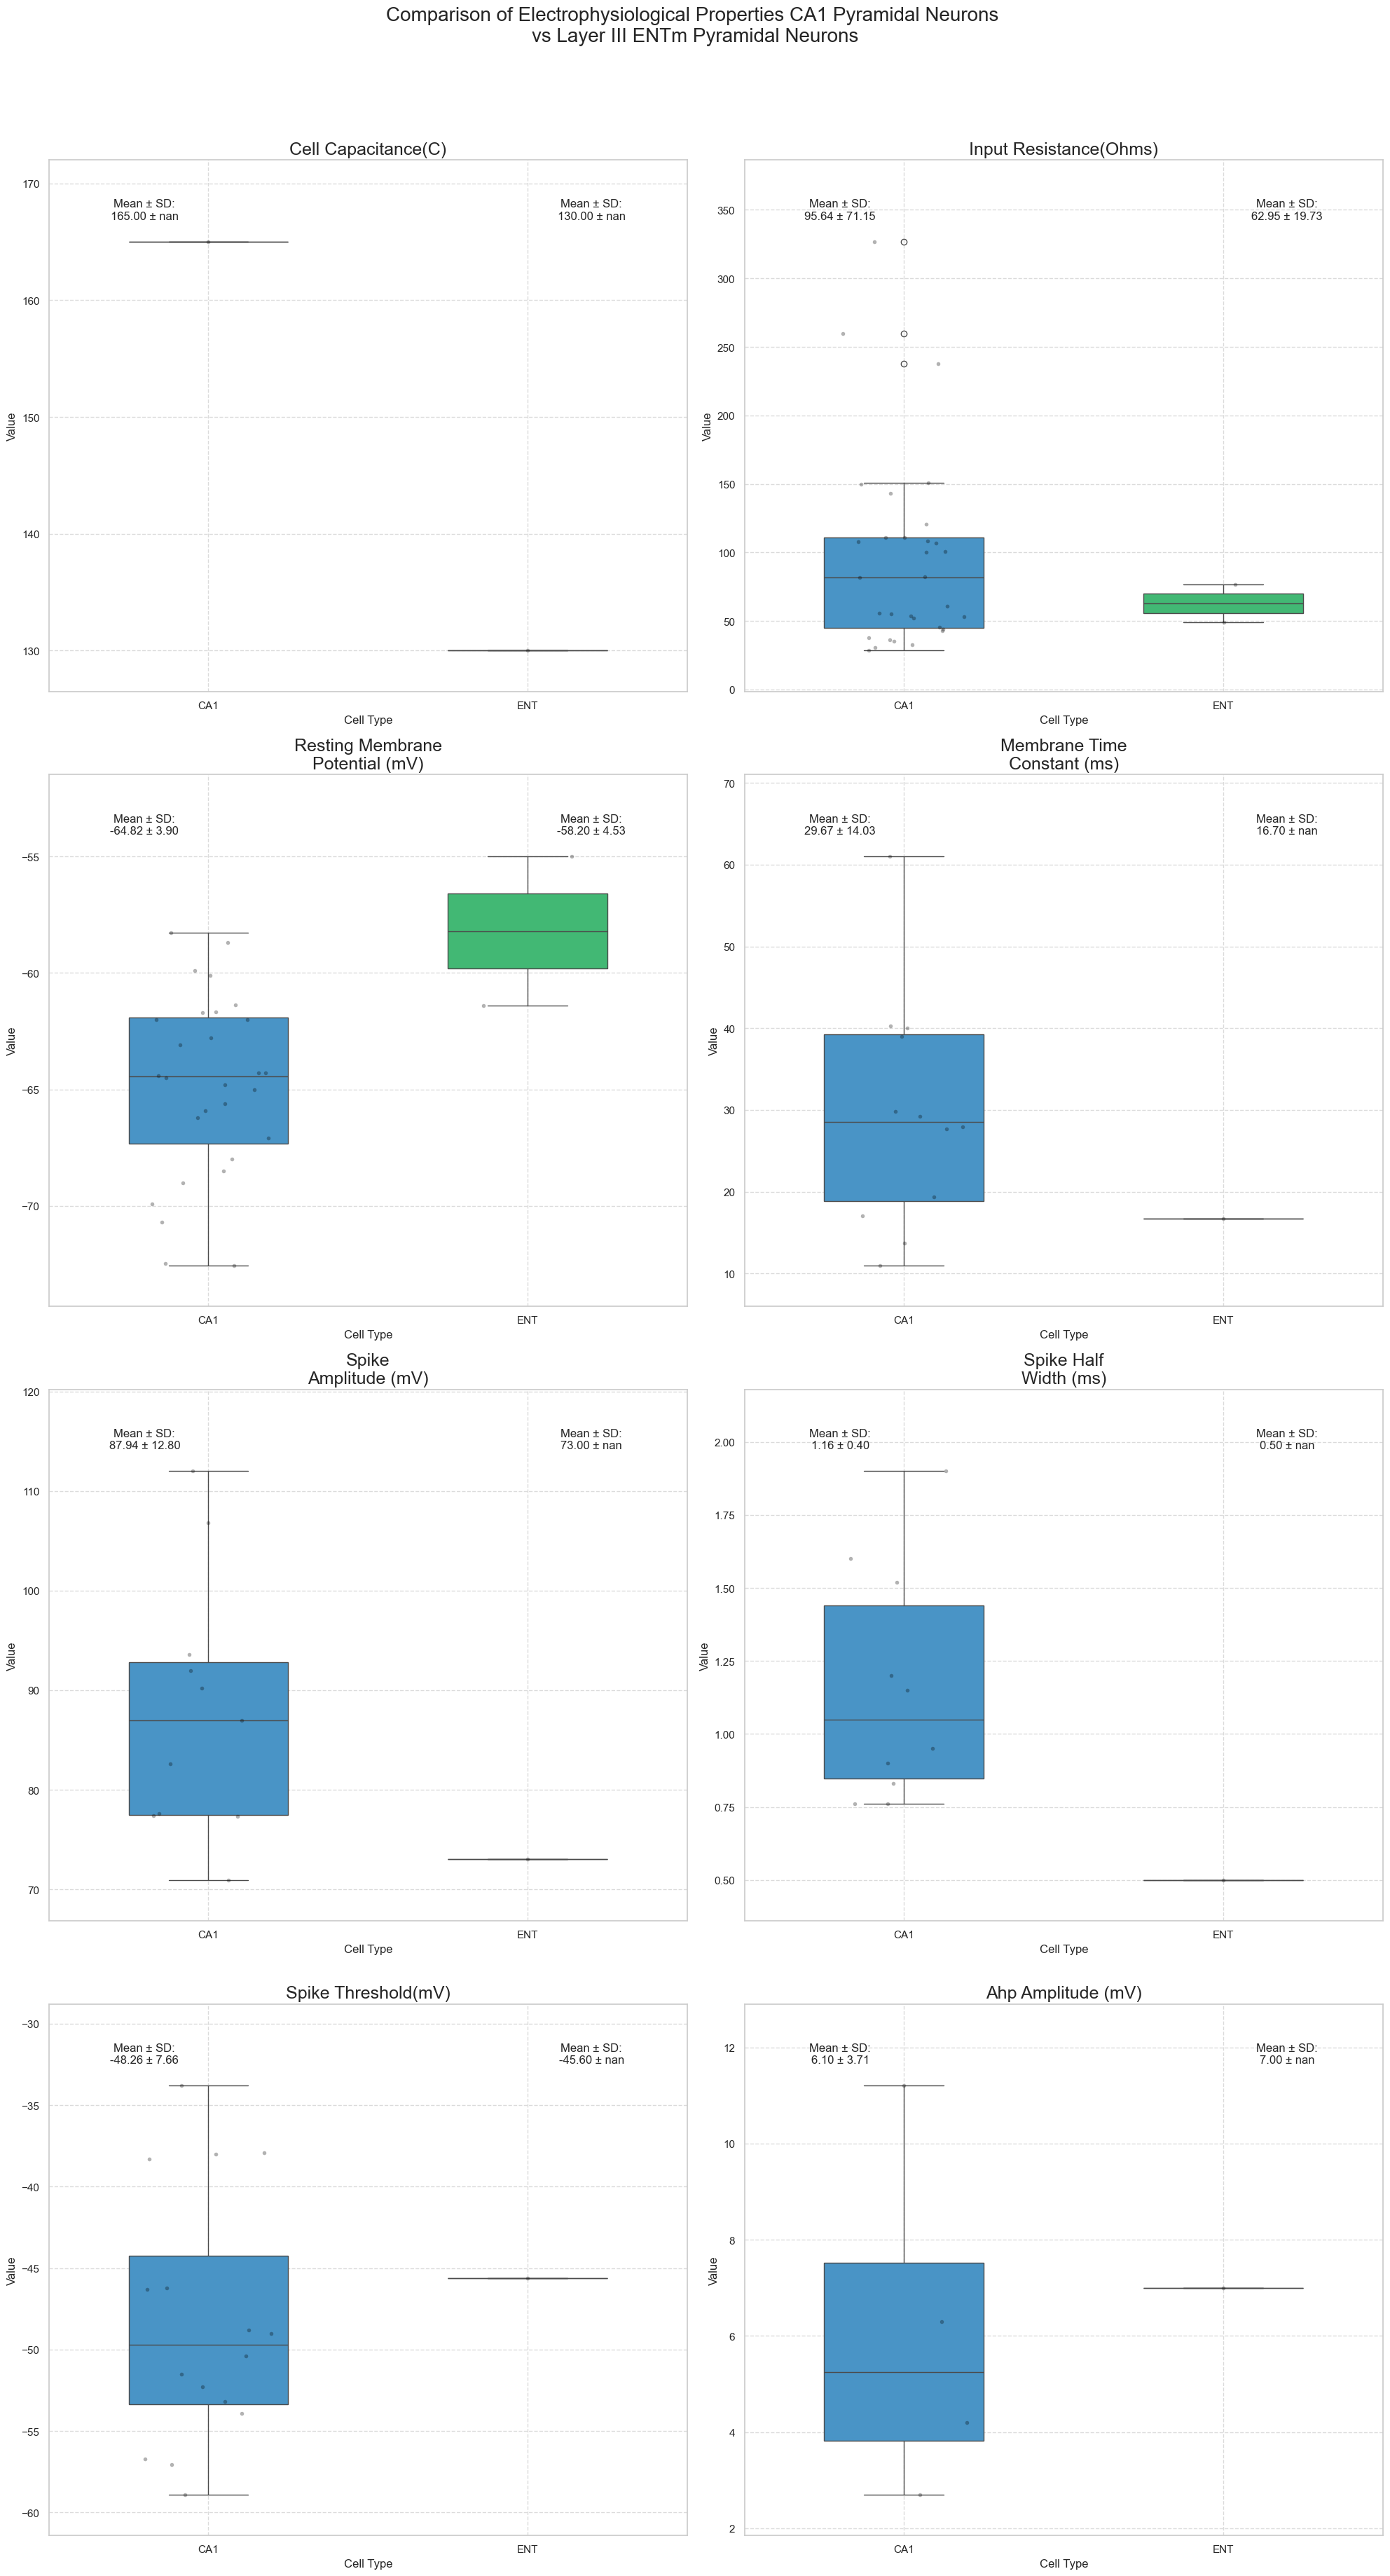

In [284]:
def plot_ephys_comparisons(ca1_df, ent_df):
    # Properties to compare
    properties = {
        'CellCapacitance': 'Cell Capacitance(C)',
        'InputResistance': 'Input Resistance(Ohms)',
        'RestingMembranePotential': 'Resting Membrane\nPotential (mV)',
        'MembraneTimeConstant': 'Membrane Time\nConstant (ms)',
        'SpikeAmplitude': 'Spike\nAmplitude (mV)',
        'SpikeHalfWidth': 'Spike Half\nWidth (ms)',
        'SpikeThreshold': 'Spike Threshold(mV)',
        'AhpAmplitude': 'Ahp Amplitude (mV)'
        
    }
    
    # Create figure with subplots
    fig, axes = plt.subplots(4, 2, figsize=(20, 35))
    axes = axes.ravel()
    
    # Color palette
    colors = ['#3498db', '#2ecc71']
    
    for idx, (prop, label) in enumerate(properties.items()):
        # Prepare data
        ca1_data = pd.DataFrame({
            'Cell Type': 'CA1',
            'Value': ca1_df[prop]
        })
        ent_data = pd.DataFrame({
            'Cell Type': 'ENT',
            'Value': ent_df[prop]
        })
        data = pd.concat([ca1_data, ent_data])
        
        # Create box plot
        sns.boxplot(data=data, x='Cell Type', y='Value', hue='Cell Type',
                   ax=axes[idx], width=0.5, palette=colors, legend=False)
        
        # Add individual points
        sns.stripplot(data=data, x='Cell Type', y='Value',
                     color='black', alpha=0.3, size=4, jitter=0.2,
                     ax=axes[idx])
        
        # Calculate basic statistics
        ca1_mean = ca1_df[prop].mean()
        ent_mean = ent_df[prop].mean()
        ca1_std = ca1_df[prop].std()
        ent_std = ent_df[prop].std()
        
        # Add mean ± std annotation
        ca1_text = f'Mean ± SD:\n{ca1_mean:.2f} ± {ca1_std:.2f}'
        ent_text = f'Mean ± SD:\n{ent_mean:.2f} ± {ent_std:.2f}'
        
        y_max = data['Value'].max()
        y_min = data['Value'].min()
        y_range = y_max - y_min
        
        axes[idx].text(-0.2, y_max + y_range * 0.05, ca1_text, 
                      ha='center', va='bottom', fontsize=12)
        axes[idx].text(1.2, y_max + y_range * 0.05, ent_text, 
                      ha='center', va='bottom', fontsize=12)
        
        # Customize plot
        axes[idx].set_title(label, fontsize=18)
        axes[idx].grid(True, linestyle='--', alpha=0.7)
        
        
        # Set y-axis limits to accommodate text
        axes[idx].set_ylim(y_min - y_range * 0.1, y_max + y_range * 0.2)
            
    # Adjust layout
    plt.tight_layout()
    
    # Add overall title
    fig.suptitle('Comparison of Electrophysiological Properties CA1 Pyramidal Neurons \nvs Layer III ENTm Pyramidal Neurons',
                 fontsize=20, y=1.05)
    
    return fig

# Create and display the plot
fig = plot_ephys_comparisons(CA1_ephys_data, ENT_ephys_data)
plt.show()

To further confirm if there are statistically significant differences in the electrophysiological features for CA1 pyramidal neuron and layer III ENTm pyramidal neuron, we conduct two-sample independent t-tests for each electrophysiological features for the two cell types. Since the electrophysiological features dataframe for both cell types contains a lot of NaN values, which might result in error in t-test due to a small sample size for ENTm neuron, the NaN values in both dataframes are filled in by their corresponding columns' means.

The results of the two sample independent t-tests are displayed in the dataframe below. Using a significance level of 0.05, cell capacitance, resting membrane potential, membrane time constant, spike amplitude, and spike half width have p-values less than 0.05, meaning that there are significant differences between those electrophysiological features of CA1 pyramidal neuron and layer III ENTm pyramidal neuron.

In [30]:
# Fill all null values with the column's mean
filled_CA1_ephys_data = CA1_ephys_data.fillna(CA1_ephys_data.mean())
filled_ENT_ephys_data = ENT_ephys_data.fillna(ENT_ephys_data.mean())

ephys_feature_list = list(ENT_ephys_data.columns)
ephys_pval_list = []
for feature in ephys_feature_list:
    ephys_t, ephys_pval = ttest_ind(filled_CA1_ephys_data[feature], filled_ENT_ephys_data[feature])
    ephys_pval_list.append(ephys_pval)

C:\Users\Devin Chang\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [31]:
ephys_pval_df = pd.DataFrame().assign(feature=ephys_feature_list, p_value=ephys_pval_list)
ephys_pval_df = ephys_pval_df.assign(significance=(ephys_pval_df['p_value'] < 0.05))
ephys_pval_df

,feature,p_value,significance
0,CellCapacitance,0.000000,True
1,InputResistance,0.513270,False
2,RestingMembranePotential,0.017013,True
3,MembraneTimeConstant,0.035024,True
4,SpikeAmplitude,0.006387,True
5,SpikeHalfWidth,0.000120,True
6,SpikeThreshold,0.483360,False
7,AhpAmplitude,0.276802,False


Among the five electrophysiological features that are significantly different between CA1 pyramidal cell and layer III ENTm pyramidal neuron, we are interested in the difference in spike amplitude. To examine possible difference in gene expression that might be associated to the difference in spike amplitude, we first examine the differential gene expression between the two cell types using a heatmap, as shown below. The y-axis of the heatmap are all the genes in the sample, and the color of the heatmap indicates the difference between the mean gene expressions of CA1 and ENTm cells (CA1 - ENT) for each gene. In the heatmap, most genes have a skin-color band, which indicates that the difference in mean gene expressions for those genes are relatively small (closer to 0). However, some genes at the top and the middle of the heatmap shows red color bands that are darker than the rest of the genes, and some genes at the bottom shows a blue band, indicating that the gene expression values for those genes are relatively different for CA1 and ENTm neurons. 

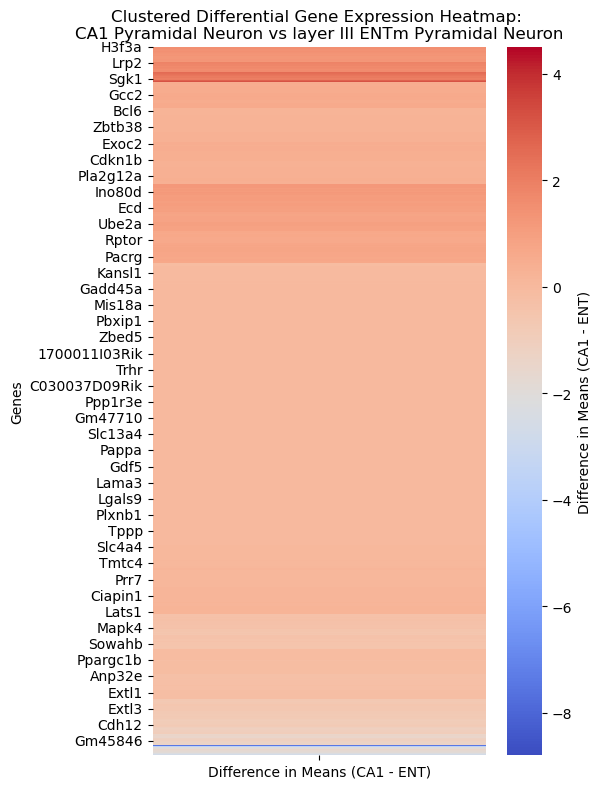

In [26]:
def DEG_heatmap(CA1_data, ENT_data):

    # Calculate mean expression for each gene in each group
    CA1_mean = CA1_data.mean()
    ENT_mean = ENT_data.mean()

    # Calculate differences in means
    mean_differences = (CA1_mean - ENT_mean).to_frame(name='Difference in Means (CA1 - ENT)')
    
    # Perform hierarchical clustering on rows (genes)
    linkage_matrix = linkage(mean_differences, method='ward')
    clustered_order = leaves_list(linkage_matrix)

    # Reorder genes based on clustering
    mean_differences_clustered = mean_differences.iloc[clustered_order]
    
    # Plot the heatmap
    plt.figure(figsize=(6, 8))
    sns.heatmap(
        mean_differences_clustered,
        cmap='coolwarm',
        cbar_kws={'label': 'Difference in Means (CA1 - ENT)'},
    )
    plt.title('Clustered Differential Gene Expression Heatmap: \nCA1 Pyramidal Neuron vs layer III ENTm Pyramidal Neuron', fontsize=12)
    plt.ylabel('Genes')
    plt.tight_layout()
    plt.show()

DEG_heatmap(CA1_rnaseq_data, ENT_rnaseq_data)

Since we are interested in genes that might contribute to the difference in spike amplitudes of CA1 pyramidal neuron and layer III ENTm pyramidal neuron, we would like to select genes which their expression determines the spike amplitude of the neuron. ## cite literature ## Thus, we selected the KCNQ5 gene and the SCN8A gene for analysis. The boxplots below show the expression of the two genes in CA1 and layer III ENTm cells. The fact that the boxes of the boxplots for CA1 and ENT do not overlap for both KCNQ5 and SCN8A indicates that there are differences in the gene expression of those two genes in CA1 and layer III ENTm cells.

C:\Users\Devin Chang\AppData\Local\Temp\ipykernel_21144\2523938617.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0].boxplot([CA1_kcnq5_data, ENT_kcnq5_data], labels=["CA1", "ENT"])
C:\Users\Devin Chang\AppData\Local\Temp\ipykernel_21144\2523938617.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1].boxplot([CA1_scn8a_data, ENT_scn8a_data], labels=["CA1", "ENT"])


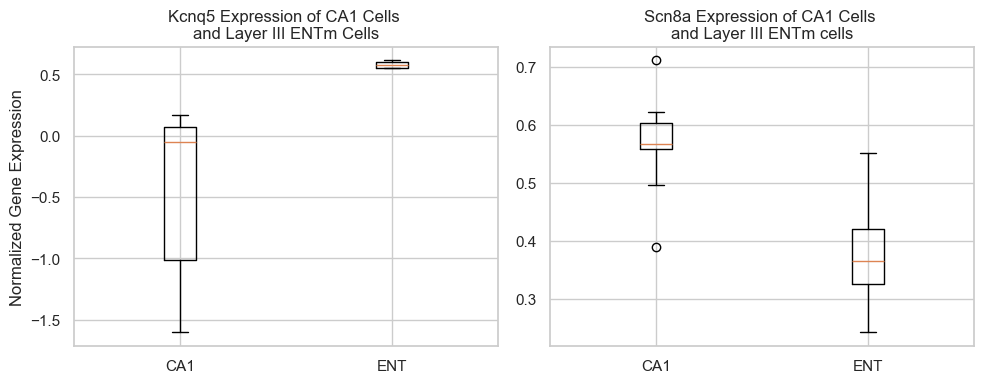

In [313]:
CA1_kcnq5_data = CA1_rnaseq_data['Kcnq5']
ENT_kcnq5_data = ENT_rnaseq_data['Kcnq5']
CA1_scn8a_data = CA1_rnaseq_data['Scn8a']
ENT_scn8a_data = ENT_rnaseq_data['Scn8a']

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].boxplot([CA1_kcnq5_data, ENT_kcnq5_data], labels=["CA1", "ENT"])
ax[0].set_title("Kcnq5 Expression of CA1 Cells \nand Layer III ENTm Cells")
ax[1].boxplot([CA1_scn8a_data, ENT_scn8a_data], labels=["CA1", "ENT"])
ax[1].set_title("Scn8a Expression of CA1 Cells \nand Layer III ENTm cells")
ax[0].set_ylabel('Normalized Gene Expression')
plt.tight_layout()
plt.show()

To confirm that the two genes are differentially expressed in the two cell types, we conduct two-sample independent t-tests on the gene expression of the two cell types for all the genes. With a significance level of 0.05, we obtained all p-values for each gene comparing the two cell types. The name of the gene, the corresponding p-value, and whether the gene is significant is organized in a dataframe (rnaseq_pval_df). The first five rows of the dataframe are displayed below.

In [314]:
# For RNA-seq data:
gene_list = list(CA1_rnaseq_data.columns)
gene_pval_list = []
for gene in gene_list:
    gene_t, gene_pval = ttest_ind(CA1_rnaseq_data[gene], ENT_rnaseq_data[gene])
    gene_pval_list.append(gene_pval)

C:\Users\Devin Chang\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [315]:
rnaseq_pval_df = pd.DataFrame().assign(gene=CA1_rnaseq_data.columns, p_value=gene_pval_list)
rnaseq_pval_df = rnaseq_pval_df.assign(significance=(rnaseq_pval_df['p_value'] < 0.05))
rnaseq_pval_df.head()

,gene,p_value,significance
0,Xkr4,0.453929,False
1,Gm1992,0.314352,False
2,Sox17,NaN,False
3,Mrpl15,0.139410,False
4,Gm37988,NaN,False


By conducting a two-sample t-test on each gene for the two cell types with a significance level of 0.05, we found that there are 2402 significant genes that are differentially expressed between CA1 pyramidal neuron and layer III EMTm pyramidal neuron. 100 examples of those differentially expressed genes are listed below. Most importantly, both KCNQ5 and SCN8A genes have p-values of less than 0.05, indicating that there is a significant difference in the gene expression of those genes in CA1 and layer III ENTm cells.

In [316]:
significant_gene_df = rnaseq_pval_df[rnaseq_pval_df['significance'] == True]
print(f'There are {len(significant_gene_df)} genes with significantly different gene expression.')
print(f'\n100 examples of such genes are: {list(significant_gene_df.head(100)['gene'])}')
significant_gene_df[significant_gene_df['gene'].isin(['Kcnq5', 'Scn8a'])]

There are 2402 genes with significantly different gene expression.

100 examples of such genes are: ['Pcmtd1', '3110035E14Rik', 'Terf1', 'Gm28376', 'Jph1', 'Tmem14a', 'Kcnq5', 'Lmbrd1', 'Arhgef4', 'Hs6st1', 'Lman2l', 'Tmem131', '2010300C02Rik', 'Rev1', 'Aff3', 'Chst10', 'Rnf149', 'Creg2', 'Slc9a2', 'Gm28175', 'Mrps9', 'Gpr45', 'Gls', 'Pgap1', 'Plcl1', 'Ndufb3', 'Tmem237', 'Ica1l', 'Carf', 'Abi2', 'Ino80d', 'Eef1b2', 'Map2', 'Unc80', 'Lancl1', 'Fn1', 'March4', 'Igfbp5', 'Arpc2', 'Wnt10a', 'Stk16', 'Dnajb2', 'Ptprn', 'Slc4a3', 'Epha4', 'Sgpp2', 'Nyap2', 'Irs1', 'Itm2c', '2810459M11Rik', 'Armc9', 'Pde6d', 'Dis3l2', 'Lrrfip1', 'Ramp1', 'Ube2f', 'Ndufa10', 'Cops9', 'Gpc1', 'Kif1a', 'Fam174a', 'St8sia4', 'Gin1', 'Pam', 'Cntnap5b', 'Cdh20', 'Tnfrsf11a', 'Phlpp1', '9330185C12Rik', 'Cntnap5a', 'Ralb', 'Ccdc93', 'Dpp10', 'Gm28928', 'Actr3', 'Lypd1', 'Ccnt2', 'Map3k19', 'Ubxn4', 'Dars', 'Thsd7b', 'Pfkfb2', 'Yod1', 'Slc41a1', 'Dstyk', 'Nfasc', 'Lrrn2', 'Atp2b4', 'Adora1', 'Klhl12', 'Timm17a', 'Nav

,gene,p_value,significance
54,Kcnq5,0.014786,True
10987,Scn8a,0.010443,True


## Conclusion & Discussion

*Fill in your discussion information here*